# UW-Madison GI Tract Image Segmentation

## Data analysis & visualisation

## Load libaries 📚

In [1]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import re
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf


In [2]:
INPUT = (128,128,3)
HEIGHT = INPUT[0]
WIDTH = INPUT[1]
name = "efficientnet-b5_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5"
backbone = 'efficientnetb5'

BATCH_SIZE = 16
EPOCHS=1
N_SPLITS=5
SELECTED_FOLD=3 # 1..5
lr = 5e-4

## Helper functions

In [3]:
# RLE de & encoder
# https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-basic-submission

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """
    
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    """
    
    Args:
        mask_rle (str): run-length as string formated (start length)
        shape (tuple of ints): (height,width) of array to return 
    
    Returns: 
        Mask (np.array)
            - 1 indicating mask
            - 0 indicating background

    """
    # Split the string by space, then convert it into a integer array
    s = np.array(mask_rle.split(), dtype=int)

    # Every even value is the start, every odd value is the "run" length
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths

    # The image image is actually flattened since RLE is a 1D "run"
    if len(shape)==3:
        h, w, d = shape
        img = np.zeros((h * w, d), dtype=np.float32)
    else:
        h, w = shape
        img = np.zeros((h * w,), dtype=np.float32)

    # The color here is actually just any integer you want!
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
        
    # Don't forget to change the image back to the original shape
    return img.reshape(shape)

# Inspired by https://www.kaggle.com/code/samuelcortinhas/uwmgi-segmentation-unet-keras-train
def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)
        
def fix_empty_slices(_row):
    if int(_row["slice_id"].rsplit("_", 1)[-1]) in remove_seg_slices[_row["class"]]:
        _row["predicted"] = ""
    return _row

def is_isolated(_row):
    return (_row["predicted"]!="" and _row["prev_predicted"]=="" and _row["next_predicted"]=="")

def fix_nc_slices(_row):
    if _row["seg_isolated"]:
        _row["predicted"] = ""
    return _row

remove_seg_slices = {
    "large_bowel": [1, 138, 139, 140, 141, 142, 143, 144],
    "small_bowel": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 138, 139, 140, 141, 142, 143, 144],
    "stomach": [1, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144],
}

In [4]:
# Data Generator 2D
# Inspired by https://www.kaggle.com/code/samuelcortinhas/uwmgi-segmentation-unet-keras-train

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size=BATCH_SIZE,  height=HEIGHT, width=WIDTH, subset="train", shuffle=False):
        super().__init__()
        self.df         = df
        self.shuffle    = shuffle
        self.subset     = subset
        self.batch_size = batch_size
        self.height     = height
        self.width      = width
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        
        X = np.empty((self.batch_size,self.width,self.height,3))
        y = np.empty((self.batch_size,self.width,self.height,3))
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            h=self.df['height'].iloc[indexes[i]]
            w=self.df['width'].iloc[indexes[i]]
            
            img = self.__load_grayscale(img_path)
            # Get paths array from
            # set X dims to image 1,2 and 3
            
            X[i,] = img
            
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    
                    # Get RLE encoded string of class, decode and create mask
                    rles = self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(w, h, 1))
                    masks = cv2.resize(masks, (self.width, self.height))
                    
                    y[i,:,:,k] = masks
        if self.subset == 'train': 
            return X, y
        else: 
            return X


    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (self.width, self.height)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img


## Config ⚙️

In [5]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'

df = pd.read_csv(TRAIN_CSV)
#df = df.sample(n=90, random_state=1)

## Extract metadata

* Restructure frame
* Extract Case ID, Day and Slice
* Extract image path
* Extract image dimensions (width, height, pixelspacing)
* Extract amount of classes shown in slice

In [6]:
df_train = pd.DataFrame({'id':df['id'][::3]})
df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values
df_train.reset_index(inplace=True,drop=True)

In [7]:
df_train["case"] = df_train["id"].apply(lambda x: re.findall("\d+",x)[0])
df_train["day"] = df_train["id"].apply(lambda x: re.findall("\d+",x)[1])
df_train["slice"] = df_train["id"].apply(lambda x: re.findall("\d+",x)[2])

In [8]:
path_df = pd.DataFrame(glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True),columns=['path'])
path_df['case'] = path_df['path'].apply(lambda x: re.findall("\d+",x)[1])
path_df['day'] = path_df['path'].apply(lambda x: re.findall("\d+",x)[2])
path_df['slice'] = path_df['path'].apply(lambda x: re.findall("\d+",x)[3])
path_df['width'] = path_df['path'].apply(lambda x: re.findall("\d+",x)[4]).astype('int64')
path_df['height'] = path_df['path'].apply(lambda x: re.findall("\d+",x)[5]).astype('int64')


path_df['pixel_x'] = path_df['path'].apply(lambda x: re.findall("\d+\.\d+",x)[0])
path_df['pixel_y'] = path_df['path'].apply(lambda x: re.findall("\d+\.\d+",x)[1])
print('Extracted metadata using RegEx from path. Example Path:')
print(path_df['path'][0])

Extracted metadata using RegEx from path. Example Path:
input/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png


## Merge dataframes into a single frame

In [9]:
df_train = df_train.merge(path_df, how='left', on=['case','day','slice'])
df_train.fillna('',inplace=True);
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sort_values(by=['case','day','slice'],ignore_index=True, inplace=True)


## 2.5D Data

In [10]:
channels=3
stride=2
for i in range(channels):
    df_train[f'path{i:02}'] = df_train.groupby(['case','day'])['path'].shift(-i*stride).fillna(method="ffill")
df_train['image_paths'] = df_train[[f'path{i:02d}' for i in range(channels)]].values.tolist()


## Final table

In [11]:
df_train

,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,pixel_x,pixel_y,count,path00,path01,path02,image_paths
0,case101_day20_slice_0001,,,,101,20,0001,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
1,case101_day20_slice_0002,,,,101,20,0002,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
2,case101_day20_slice_0003,,,,101,20,0003,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
3,case101_day20_slice_0004,,,,101,20,0004,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
4,case101_day20_slice_0005,,,,101,20,0005,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,case92_day0_slice_0140,,,,92,0,0140,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
38492,case92_day0_slice_0141,,,,92,0,0141,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
38493,case92_day0_slice_0142,,,,92,0,0142,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...
38494,case92_day0_slice_0143,,,,92,0,0143,input/uw-madison-gi-tract-image-segmentation/t...,266,266,1.50,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...


## Exploratory Data Analysis

* 57% of the slices have no segmentation at all
* Left bowel is most segmented, stomach least

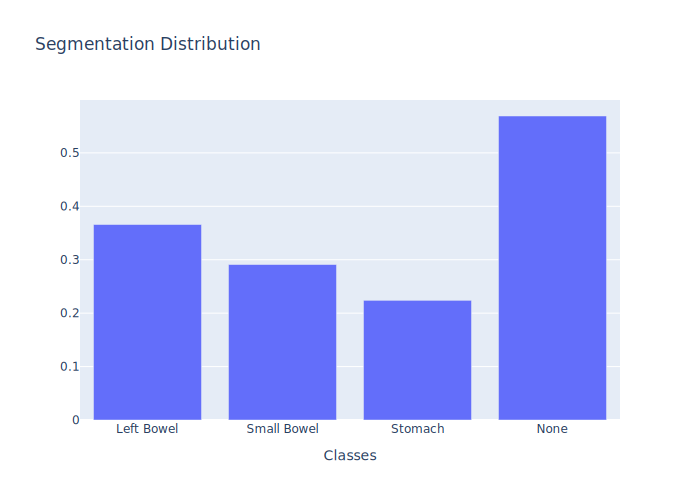

In [25]:
import plotly.graph_objects as go

dist = np.mean(df_train.iloc[:,1:4]!='',axis=0)
no_masks = np.sum(df_train['count'] == 0)/df_train.shape[0]
dist = np.append(dist.values, no_masks)

fig = go.Figure([go.Bar(x=['Left Bowel', 'Small Bowel', 'Stomach', 'None'], y=dist)])
fig.update_traces( textposition='outside')
fig.update_layout(title_text='Segmentation Distribution', xaxis_title="Classes")
fig.show("svg")

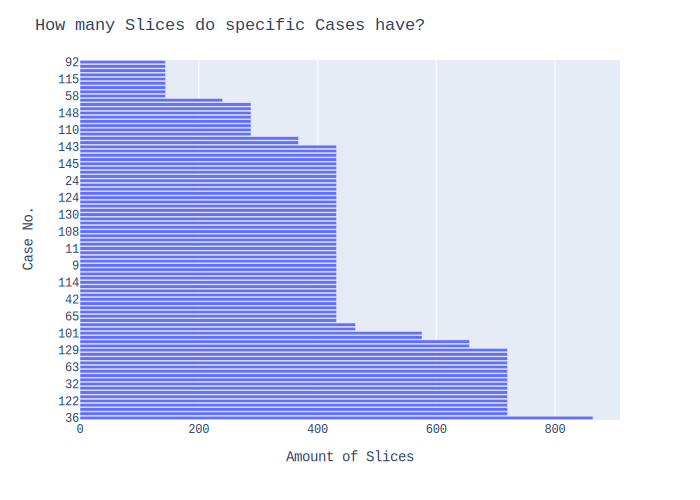

In [26]:
cases = df_train["case"].value_counts().reset_index()

fig = px.bar(cases, x='case', y='index')
fig.update_layout(
    font_family="Courier New",
    title="How many Slices do specific Cases have?",
    xaxis_title="Amount of Slices",
    yaxis_title="Case No.",
)

fig.show("svg")

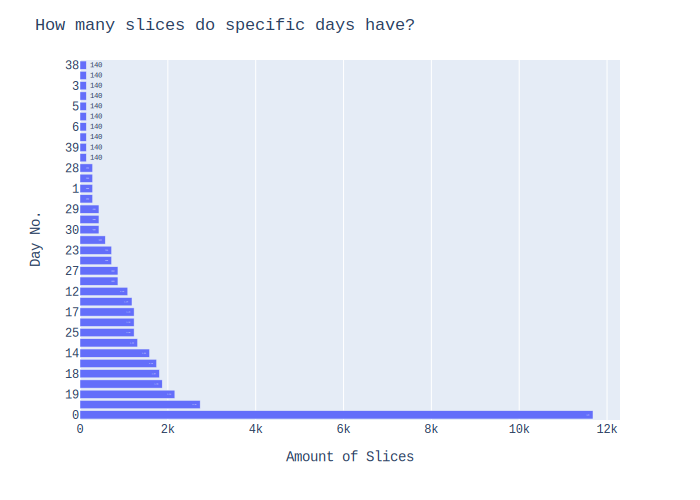

In [27]:
days = df_train["day"].value_counts().reset_index()

fig = px.bar(days, x='day', y='index', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="How many slices do specific days have?",
    xaxis_title="Amount of Slices",
    yaxis_title="Day No.",
)
fig.show("svg")

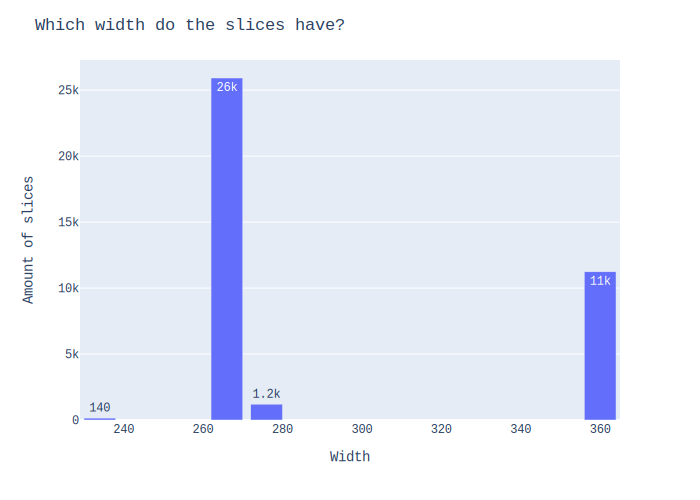

In [28]:
width = df_train["width"].value_counts().reset_index()

fig = px.bar(width, x='index', y='width', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="Which width do the slices have?",
    xaxis_title="Width",
    yaxis_title="Amount of slices",
)
fig.show("svg")

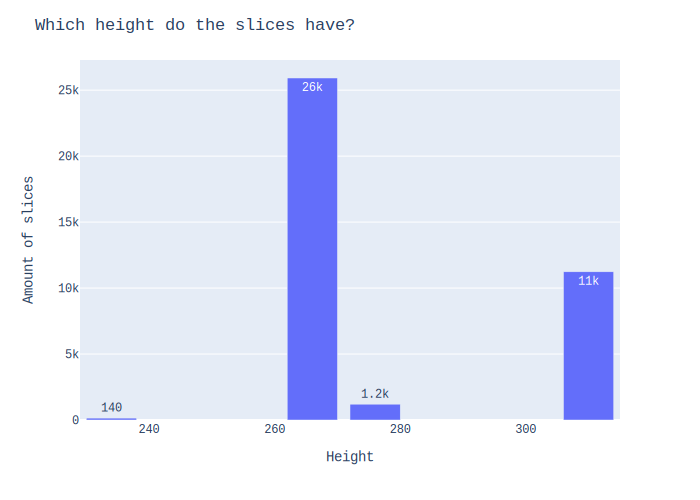

In [29]:
height = df_train["height"].value_counts().reset_index()

fig = px.bar(height, x='index', y='height', text_auto='.2s')
fig.update_layout(
    font_family="Courier New",
    title="Which height do the slices have?",
    xaxis_title="Height",
    yaxis_title="Amount of slices",
)
fig.show("svg")

In [30]:
df_train["pixel_x"].value_counts().reset_index()

,index,pixel_x
0,1.50,37296
1,1.63,1200


In [31]:
df_train["pixel_y"].value_counts().reset_index()

,index,pixel_y
0,1.50,37296
1,1.63,1200


In [19]:
# Next -> Display some slices + masks